### **Salary prediction** 
Predicting salaries based on various features is crucial for informed decision-making in HR, finance, and economic planning. This assignment aims to develop a robust salary prediction model using unsupervised learning, supervised learning, and neural networks. Each method plays a specific role in achieving our goals.

**Feature selection and Supervised Learning**
    
- Achieve Predictive Accuracy: Use algorithms like linear regression and decision trees. V
- Evaluate Models: Measure performance with metrics like MSE and cross-validation. V 
- Determine Feature Importance: Identify key predictors of salary. V
- Prepare Data: Detect and handle anomalies. V

**Unsupervised Learning**

- Identify Patterns and Clusters: Group similar job roles or experience levels. V
- Reduce Dimensionality: Focus on significant features. V


**Neural Networks**

- Model Complex Relationships: Capture intricate patterns and interactions.
- Ensure Flexibility and Scalability: Handle large datasets and many features.
- Leverage Large Data: Improve learning and generalization with extensive data.

In [8]:
import pandas as pd

# Imports custom functions. see ./functions folder.
from functions.wrangling import preprocessing, decode_column  
from functions.plotting import scatter_plot, bar_plot, corr_mx
from functions.ML import UMAP_reduction,DBSCAN_cluster, KMEANS_cluster, RF_train_test, AGGL_cluster

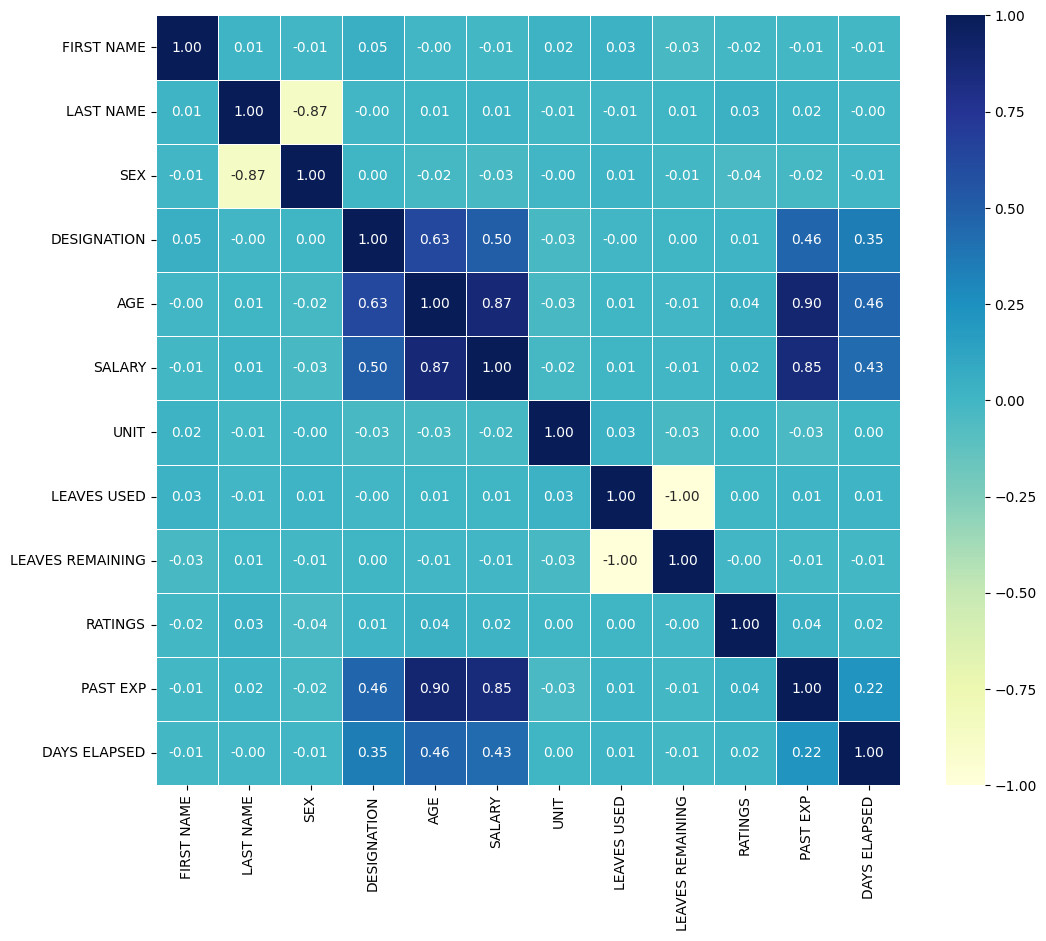

<class 'pandas.core.frame.DataFrame'>
Index: 2631 entries, 0 to 2638
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FIRST NAME        2631 non-null   int64  
 1   LAST NAME         2631 non-null   int64  
 2   SEX               2631 non-null   int64  
 3   DOJ               2631 non-null   float64
 4   CURRENT DATE      2631 non-null   float64
 5   DESIGNATION       2631 non-null   int64  
 6   AGE               2631 non-null   float64
 7   SALARY            2631 non-null   float64
 8   UNIT              2631 non-null   int64  
 9   LEAVES USED       2631 non-null   float64
 10  LEAVES REMAINING  2631 non-null   float64
 11  RATINGS           2631 non-null   float64
 12  PAST EXP          2631 non-null   float64
 13  DAYS ELAPSED      2631 non-null   float64
dtypes: float64(9), int64(5)
memory usage: 308.3 KB


In [35]:
## PRE-PROCESSING
df = pd.read_csv("./data/salary_data.csv").dropna()

df['DOJ'] = pd.to_datetime(df['DOJ'])
df['CURRENT DATE'] = pd.to_datetime(df['CURRENT DATE'])
df['DAYS ELAPSED'] = (df['CURRENT DATE'] - df['DOJ']).dt.days

# Returns preprocessed df and exposes tools to decode it 
preprocessed_df, encodings_cat, label_encoders, num_scaler = preprocessing(df) 
preprocessed_df
corr_mx(preprocessed_df.drop(["DOJ","CURRENT DATE"], axis=1))

preprocessed_df.info()

**Feature selection and Supervised Learning**

Some features have been randomly removed, now use a RF algorithms to determine which ones are the most important ones.

Training a Random Forest Regressor to predict salary, removing least important features results in improved accuracy.

On average, the features selected model results in greater accuracy, with 4/5 iteration performing better than non features selected model.


In [10]:
acc_scores = pd.DataFrame(columns=["Itr","Not pruned", "Pruned"])
itrs = 5 

score_RF, feat_imp_RF, fitted_model_RF = RF_train_test(preprocessed_df, "SALARY")
bar_plot(feat_imp_RF, ["Importance","Feature"], title="Feature importances with GINI SCORE")

for itr in range(0,itrs):
    
    # With all features
    score_RF, feat_imp_RF, fitted_model_RF = RF_train_test(preprocessed_df, "SALARY")


    # With only important features
    selected_df = preprocessed_df.drop(preprocessed_df[["FIRST NAME", "LAST NAME", "DOJ", "CURRENT DATE"]], axis=1)
    score_RF_pr, feat_imp_RF_pr, fitted_model_RF_pr = RF_train_test(selected_df, "SALARY")
    
    # Save results to output df
    new_results = pd.DataFrame({"Itr": [itr], "Not pruned": [score_RF], "Pruned": [score_RF_pr]})
    acc_scores = pd.concat([acc_scores, new_results], ignore_index=True)

acc_scores

selected_df = preprocessed_df.drop(preprocessed_df[["FIRST NAME", "LAST NAME", "DOJ", "CURRENT DATE"]], axis=1)




/tmp/ipykernel_19717/3506410002.py:19: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



**Dimensionality reduction and Clustering**

"FIRST NAME", "LAST NAME", "DOJ", "CURRENT DATE" features were removed. 
These are highly specific and add lots of noise to the data. Time stayed at the company was accounted as a numerical value by calculating the days eleapsed between DOJ and Current date. 

Salary is removed during clustering, as it is the target variable and we are looking for contributing factor in the salary.

This was done in the preprocessing.

In [44]:
df_no_sal = selected_df.drop(selected_df[["SALARY"]], axis=1)
umap_df = UMAP_reduction(df_no_sal, rng=60)


/home/marcello/miniconda3/envs/data_analysis/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



**Unsupervised Findings**

Relationship between salary and designation can be noticed by connecting the two plots, clustering observed in UMAP is further confirmed using various clustering algorithms.  


- There are 2 main clusters of data analysts with a broad range of salaries.
- Senior analysts are payed more than data analysts.
- Associates make as much as Senior Analysts.  
- Managers have the second highest salary.
- Directors earn the most money. 

The top payed person is a director.

Furthermore, it can be inferred that age play a important role in salary earning, which is in line with what found with Gini scoring.

In [45]:
preprocessed_df_1 = preprocessed_df.reset_index(drop=True)
umap_df_1= umap_df.reset_index(drop=True)

combined_df = pd.concat([preprocessed_df_1, umap_df_1], axis=1, join='outer')

# Decodes and builds df used for plotting. Clustering algorithms are applied as well.
combined_df["DES"] = decode_column(preprocessed_df, "DESIGNATION", label_encoder=label_encoders["DESIGNATION"])
combined_df["SAL"] =preprocessed_df["SALARY"]
combined_df["AGE"] =preprocessed_df["AGE"]

dbscan_sel_clusters = DBSCAN_cluster(umap_df[["umap1","umap2"]])
#kmeans_sel_clusters = KMEANS_cluster(umap_df[["umap1","umap2"]], clusters=19)
#agg_sel_clusters = AGGL_cluster(df_no_sal, clusters=19)


combined_df["cluster_DB"] = dbscan_sel_clusters["cluster"]
#combined_df["cluster_K"] = kmeans_sel_clusters["cluster"]
#combined_df["cluster_Agglomerative"] = agg_sel_clusters["cluster"]

# PLots umap scatterplots with different layers of information.
scatter_plot(combined_df, ["umap1", "umap2"], "DES", title="Designation umap")
scatter_plot(combined_df, ["umap1", "umap2"], "AGE", title="Age umap")
scatter_plot(combined_df, ["umap1", "umap2"], "SAL", title="Salary umap")
scatter_plot(combined_df, ["umap1", "umap2"], "cluster_DB", title="DBSCAN umap")
#scatter_plot(combined_df, ["umap1", "umap2"], "cluster_K", title="KMEANS umap")
#scatter_plot(combined_df, ["umap1", "umap2"], "cluster_Agglomerative", title="Agglomerative umap")




**Neural Network**

Using a Sequential Neural Network we can use the most important features to predict a likely salary someone  is likely to obtain givent the most important features provided in this dataset.

This is achieved by using a 4 layer regression model, trained from scratch. 

In [6]:
import logging
import os

# Set logging level to suppress certain TensorFlow warnings and errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Set TensorFlow logging to suppress INFO, WARNING, and ERROR messages

# Create a custom logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Set logger to display INFO level messages

# Filter out specific TensorFlow CUDA-related warnings and errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('tensorflow.compiler').setLevel(logging.ERROR)
logging.getLogger('tensorflow.compiler.xla').setLevel(logging.ERROR)
logging.getLogger('tensorflow.compiler.tfrt').setLevel(logging.ERROR)
logging.getLogger('tensorflow.compiler.mlir').setLevel(logging.ERROR)
# Actual TensorFlow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
import sklearn.model_selection


# Splitting into training and testing sets
X_train, X_holdout, y_train, y_holdout = sklearn.model_selection.train_test_split(preprocessed_df.drop(columns=["SALARY"]) ,
                                                                            preprocessed_df["SALARY"], 
                                                                            test_size=0.2, 
                                                                            random_state=42)

#Split the holdout (test) set into evaluation and testing sets (50% each)
X_eval, X_test, y_eval, y_test = sklearn.model_selection.train_test_split(X_holdout, y_holdout, test_size=0.6, random_state=42)



In [7]:

# Model structure
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(13,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear')  # Linear activation for regression
])

model.compile(optimizer='adam',
              loss='mae',  # Mean Absolute Error
              metrics=['mse'])   

model.summary()
model.fit(X_train, y_train, epochs=100, validation_data=(X_eval, y_eval))

model.save("./temp/model/salary_pred.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2399 - mse: 23.5158 - val_loss: 2.2004 - val_mse: 29.2577
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1142 - mse: 24.7583 - val_loss: 2.1857 - val_mse: 29.1670
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9510 - mse: 24.8964 - val_loss: 2.2351 - val_mse: 30.0935
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8378 - mse: 22.8741 - val_loss: 2.2043 - val_mse: 29.1118
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9577 - mse: 25.2828 - val_loss: 2.1993 - val_mse: 29.1686
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8784 - mse: 23.4045 - val_loss: 2.1888 - val_mse: 29.2690
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9442 - mse: 21.8187 - val_loss: 2.2082 - val_mse: 30.2369
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8033 - mse: 21.3719 - val_loss: 2.2132 - val_mse: 30.2019
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

In [8]:
loaded_model = tf.keras.models.load_model("./temp/model/salary_pred.keras")

In [9]:
y_pred = loaded_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared error: ",mse)
print("Mean Absolute error:", mae)
print(f"R2 score:{r2*100}% ",)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared error:  2.8724636136925246
Mean Absolute error: 0.7106092891638986
R2 score:80.66847094808924% 


In [43]:
#Reverse the scaling and outputs the predicted salaries
num_scaler["SALARY"].inverse_transform(y_pred)

array([[ 72716.85 ],
       [ 47296.973],
       [ 46215.016],
       [ 45704.53 ],
       [ 42682.383],
       [ 45218.094],
       [ 44505.527],
       [ 44729.004],
       [ 48578.293],
       [ 45520.863],
       [ 45599.4  ],
       [ 46916.594],
       [ 44915.504],
       [ 53367.105],
       [ 45963.26 ],
       [ 47819.324],
       [ 45957.61 ],
       [ 48482.246],
       [ 44840.406],
       [ 54685.633],
       [ 46533.72 ],
       [ 45230.05 ],
       [ 45571.824],
       [ 46713.023],
       [ 45265.4  ],
       [ 45341.516],
       [ 49113.332],
       [ 46699.11 ],
       [ 45399.62 ],
       [ 56213.09 ],
       [144847.83 ],
       [ 45738.047],
       [ 47858.918],
       [ 44904.535],
       [ 46482.46 ],
       [ 47875.555],
       [ 57969.33 ],
       [ 48644.695],
       [168723.75 ],
       [165363.44 ],
       [ 47915.125],
       [ 46383.93 ],
       [135290.22 ],
       [ 45694.63 ],
       [ 47325.04 ],
       [ 46682.938],
       [ 52797.55 ],
       [ 4695